# PASCAL VOC Dataset

* [TensforFlwo Datasets - voc](https://www.tensorflow.org/datasets/catalog/voc)

> PASCAL Visual Object Classes Challenge, corresponding to the Classification and Detection competitions.

<img src="image/pascal_voc_xml_example.png" align="left" width=350/>

In [1]:
from typing import (
    Tuple,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import sys
sys.path.append("../../lib")

In [14]:
%load_ext autoreload
%autoreload 2

from util_tf.tfds import (
    convert_pascal_voc_bndbox_to_yolo_bbox,
    generate_yolo_v1_label_from_pascal_voc,
    generate_yolo_v1_data_from_pascal_voc,
)
from util_tf.geometry.euclidean import (
    convert_box_corner_coordinates_to_centre_w_h
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TensorFlow Datasets 

TFDS has its own Bounding Box representation class as ```(ymin,xmin,ymax,xmax)```. Bounding boxes in TFDS Datasets is reformatted into this format.

* [tfds.features.BBox](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBox)

In [4]:
bbox = tfds.features.BBox(
    ymin=0.0, xmin=1.0, ymax=1.1, xmax=2.1
)
list(bbox)

[0.0, 1.0, 1.1, 2.1]

# TensorFlow Datasets Pascal VOC

TFDS BBox format is ```(y_min, x_min, y_max, x_max)``` and normalized by the image size.

```
tfds.features.BBox(
    ymin, xmin, ymax, xmax
)
```

* [datasets/tensorflow_datasets/object_detection/voc.py](https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/object_detection/voc.py#L89-121)

```
def _get_example_objects(annon_filepath):
  """Function to get all the objects from the annotation XML file."""
  with tf.io.gfile.GFile(annon_filepath, "r") as f:
    root = xml.etree.ElementTree.parse(f).getroot()

    # Disable pytype to avoid attribute-error due to find returning
    # Optional[Element]
    # pytype: disable=attribute-error
    size = root.find("size")
    width = float(size.find("width").text)
    height = float(size.find("height").text)

    for obj in root.findall("object"):
      # Get object's label name.
      label = obj.find("name").text.lower()
      # Get objects' pose name.
      pose = obj.find("pose").text.lower()
      is_truncated = obj.find("truncated").text == "1"
      is_difficult = obj.find("difficult").text == "1"
      bndbox = obj.find("bndbox")
      xmax = float(bndbox.find("xmax").text)
      xmin = float(bndbox.find("xmin").text)
      ymax = float(bndbox.find("ymax").text)
      ymin = float(bndbox.find("ymin").text)
      yield {
          "label": label,
          "pose": pose,
          "bbox": tfds.features.BBox(
              ymin / height, xmin / width, ymax / height, xmax / width
          ),
          "is_truncated": is_truncated,
          "is_difficult": is_difficult,
      }
```

In [5]:
voc, info = tfds.load(
    name='voc', 
    # split='train',
    data_dir="/Volumes/SSD/data/tfds/",
    with_info=True,
)
info

INFO:absl:No config specified, defaulting to config: voc/2007
INFO:absl:Load dataset info from /Volumes/SSD/data/tfds/voc/2007/4.0.0
INFO:absl:Reusing dataset voc (/Volumes/SSD/data/tfds/voc/2007/4.0.0)
INFO:absl:Constructing tf.data.Dataset voc for split None, from /Volumes/SSD/data/tfds/voc/2007/4.0.0


tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='/Volumes/SSD/data/tfds/voc/2007/4.0.0',
    file_format=tfrecord,
    download_size=868

INFO:absl:Was not able to auto-infer label.
2023-03-05 14:34:51.399771: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


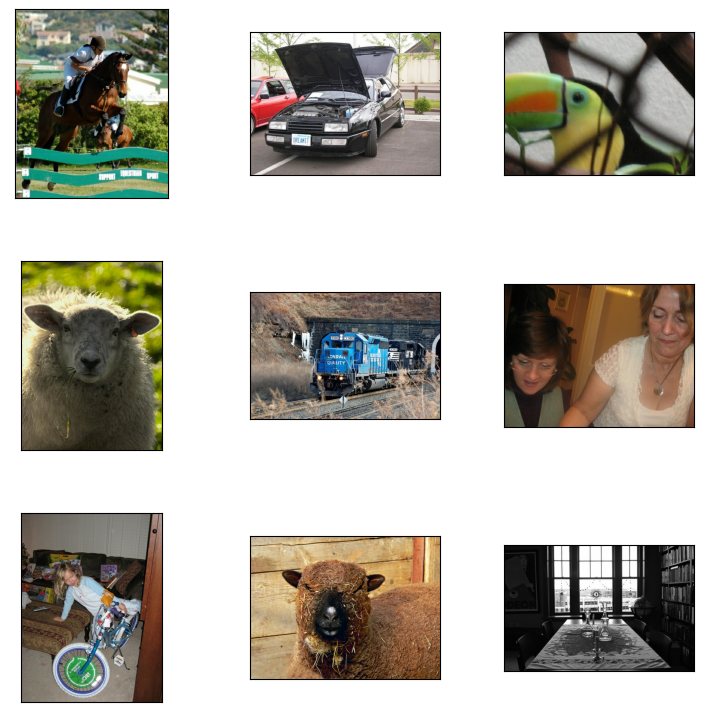

In [6]:
fig = tfds.show_examples(voc['train'], info)

,image,image/filename,labels,labels_no_difficult,objects/bbox,objects/is_difficult,objects/is_truncated,objects/label,objects/pose
0,,007308.jpg,12 (horse)14 (person),12 (horse)14 (person),,FalseFalseFalseTrue,FalseFalseTrueTrue,12 (horse)14 (person)12 (horse)14 (person),4 (unspecified)4 (unspecified)4 (unspecified)4 (unspecified)
1,,006362.jpg,6 (car),6 (car),,FalseFalse,FalseTrue,6 (car)6 (car),4 (unspecified)4 (unspecified)

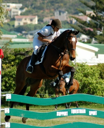
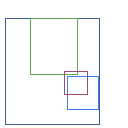
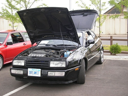
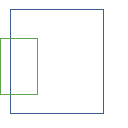

In [7]:
tfds.as_dataframe(voc['train'].take(2), info)

---
# Bounding Box

In [8]:
def extract_bounding_box(dataset):
    return dataset['objects']['bbox']

# unbatch() because each row has multiple bounding boxes
# Unbatch() is basically flatten
boxes = voc['train'].take(1).map(extract_bounding_box).unbatch()
print(boxes)
for box in boxes:
    print(box)

<_UnbatchDataset element_spec=TensorSpec(shape=(4,), dtype=tf.float32, name=None)>
tf.Tensor([0.14375    0.0437018  0.97083336 0.7763496 ], shape=(4,), dtype=float32)
tf.Tensor([0.14583333 0.24164525 0.57916665 0.6066838 ], shape=(4,), dtype=float32)
tf.Tensor([0.6        0.5244216  0.8541667  0.76606685], shape=(4,), dtype=float32)
tf.Tensor([0.56041664 0.5012854  0.7395833  0.6863753 ], shape=(4,), dtype=float32)


In [9]:
yolo_bboxes = boxes.flat_map(convert_pascal_voc_bndbox_to_yolo_bbox)
for box in yolo_bboxes:
    print(box)

tf.Tensor([[0.41002572 0.5572917  0.7326478  0.82708335]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.42416453 0.36249998 0.36503854 0.43333334]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.64524424 0.7270833  0.24164528 0.25416666]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.59383035 0.65       0.18508995 0.17916667]], shape=(1, 4), dtype=float32)


# Dataset(label)

In [10]:
def extract_label(dataset):
    return dataset['objects']['label']

labels = voc['train'].take(1).map(extract_label).unbatch()
for index, label in enumerate(labels):
    print(index, label)

0 tf.Tensor(12, shape=(), dtype=int64)
1 tf.Tensor(14, shape=(), dtype=int64)
2 tf.Tensor(12, shape=(), dtype=int64)
3 tf.Tensor(14, shape=(), dtype=int64)


# Dataset(image)

In [11]:
def extract_image(dataset):
    image = dataset['image'][tf.newaxis, ...]
    return tf.repeat(
        input=image,
        repeats=2,
        axis=0
    )
    

images = voc['train'].take(1).map(extract_image)
for index, img in enumerate(images):
    print(index, img.shape)

0 (2, 480, 389, 3)


---


# YOLO v1 Labels

In [12]:
tf.config.run_functions_eagerly(False)

In [39]:
labels = voc['train'].take(3).flat_map(generate_yolo_v1_label_from_pascal_voc)
for index, label in enumerate(labels):
    print(index, label)

0 tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         1.         0.41002572 0.5572917  0.7326478
 0.82708335], shape=(25,), dtype=float32)
1 tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         1.         0.42416453 0.36249998 0.36503854
 0.43333334], shape=(25,), dtype=float32)
2 tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         1.         0.64524424 0.7270833  0.24164528
 0.25416666], shape=(25,), dtype=float32)
3 tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.       

# YOLO v1 Data

Generate data for supervised trainining as ```(input, label)``` format where ```input``` is a resized image of shape ```(448,448,3)``` and ```label``` is YOLO v1 label of format ```(C,P)``` where ```P=(cp,x,y,w,h)```.

In [38]:
data = voc['train'].take(3).flat_map(generate_yolo_v1_data_from_pascal_voc)
count = 0
for index, row in enumerate(data):
    print(index, row[0].shape, row[1].shape)
    count += 1

print(count)

tf.data.Dataset.cardinality(data).numpy()

0 (448, 448, 3) (25,)
1 (448, 448, 3) (25,)
2 (448, 448, 3) (25,)
3 (448, 448, 3) (25,)
4 (448, 448, 3) (25,)
5 (448, 448, 3) (25,)
6 (448, 448, 3) (25,)
7


-2